In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


from lerobot.policies.smolandfast.tokenizer import Autoencoder
from torch.optim.lr_scheduler import CosineAnnealingLR

from pathlib import Path
from tqdm import tqdm
import torch
from lerobot.datasets.utils import cycle

from lerobot.configs.types import FeatureType
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.smolandfast.configuration_smolandfast import SMOLANDFASTConfig

import matplotlib.pyplot as plt

from lerobot.processor.normalize_processor import NormalizerProcessorStep
from lerobot.configs.types import FeatureType, NormalizationMode, PolicyFeature

/lerobot-experiments/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_directory = Path("outputs/train/example_pusht")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda")

In [3]:
DATASET_PATH = "lerobot/pusht"

dataset_metadata = LeRobotDatasetMetadata(DATASET_PATH)
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

cfg = SMOLANDFASTConfig(input_features=input_features,
                        output_features=output_features)

delta_timestamps = {
        "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
    }

# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset(DATASET_PATH, delta_timestamps=delta_timestamps)

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=32,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)
dl_iter = cycle(dataloader)

def _build_min_max_normalizer(dataset: LeRobotDataset) -> NormalizerProcessorStep:
    action_shape = tuple(dataset.meta.shapes["action"])
    features = {"action": PolicyFeature(type=FeatureType.ACTION, shape=action_shape)}
    norm_map = {FeatureType.ACTION: NormalizationMode.MIN_MAX}
    normalizer = NormalizerProcessorStep.from_lerobot_dataset(dataset, features, norm_map)
    return normalizer

normalizer = _build_min_max_normalizer(dataset)

def preprocess(raw_batch):
    return normalizer._normalize_action(torch.as_tensor(raw_batch['action'], dtype=torch.float32), inverse=False).cpu()

In [9]:
def apply_affine_transform(points_tensor, transform_type, shift_amount=0.1):
    """
    Applies a specified affine transformation to a tensor of 2D points.

    The points are assumed to be in a space defined from [-1, 1] for both axes.
    Shift operations are only applied if the resulting points all remain
    within this [-1, 1] boundary.

    Args:
        points_tensor (torch.Tensor): A tensor of shape (N, 2) where N is
                                      the number of points.
        transform_type (str): The type of transformation to apply.
            Valid options are:
            - 'rotate_left_90'
            - 'rotate_right_90'
            - 'rotate_180'
            - 'mirror_y_axis' (reflect across the vertical axis, x -> -x)
            - 'mirror_x_axis' (reflect across the horizontal axis, y -> -y)
            - 'shift_left'
            - 'shift_right'
            - 'shift_up'
            - 'shift_down'
        shift_amount (float, optional): The magnitude of the shift for
                                        shift operations. Defaults to 0.1.

    Returns:
        torch.Tensor: The transformed tensor of points. Returns the
                      original tensor if a shift is out of bounds or
                      if the transform_type is unknown.
    """
    
    # --- Input Validation ---
    if not isinstance(points_tensor, torch.Tensor):
        raise TypeError("Input 'points_tensor' must be a torch.Tensor")

    if points_tensor.numel() == 0:
        return points_tensor  # Return empty tensor if input is empty

    if points_tensor.dim() != 2 or points_tensor.shape[1] != 2:
        raise ValueError(f"Input tensor must have shape (N, 2), but got {points_tensor.shape}")

    # --- Transformation Logic ---
    # Create a copy to avoid in-place modification of the original
    transformed_points = points_tensor.clone()

    if transform_type == 'rotate_left_90':
        # (x, y) -> (-y, x)
        transformed_points[:, 0] = -points_tensor[:, 1]
        transformed_points[:, 1] =  points_tensor[:, 0]
        return transformed_points

    elif transform_type == 'rotate_right_90':
        # (x, y) -> (y, -x)
        transformed_points[:, 0] =  points_tensor[:, 1]
        transformed_points[:, 1] = -points_tensor[:, 0]
        return transformed_points

    elif transform_type == 'rotate_180':
        # (x, y) -> (-x, -y)
        transformed_points = -points_tensor
        return transformed_points

    elif transform_type == 'mirror_y_axis':
        # (x, y) -> (-x, y)
        transformed_points[:, 0] = -points_tensor[:, 0]
        return transformed_points

    elif transform_type == 'mirror_x_axis':
        # (x, y) -> (x, -y)
        transformed_points[:, 1] = -points_tensor[:, 1]
        return transformed_points

    # --- Shift Operations with Boundary Checks ---

    # Define shift vectors
    shifts = {
        'shift_left':  torch.tensor([-shift_amount, 0.0], device=points_tensor.device, dtype=points_tensor.dtype),
        'shift_right': torch.tensor([ shift_amount, 0.0], device=points_tensor.device, dtype=points_tensor.dtype),
        'shift_up':    torch.tensor([0.0,  shift_amount], device=points_tensor.device, dtype=points_tensor.dtype),
        'shift_down':  torch.tensor([0.0, -shift_amount], device=points_tensor.device, dtype=points_tensor.dtype)
    }

    if transform_type in shifts:
        shift_vector = shifts[transform_type]
        # Apply the shift
        candidate_points = points_tensor + shift_vector

        # Check if all points are within the [-1, 1] boundary
        # We use .all() to ensure every single point is valid
        if (candidate_points >= -1.0).all() and (candidate_points <= 1.0).all():
            return candidate_points
        else:
            print(f"Warning: Shift '{transform_type}' with amount {shift_amount} would move points "
                  "out of the [-1, 1] bounds. Returning original tensor.")
            return points_tensor  # Return original, unmodified tensor
    
    else:
        print(f"Warning: Unknown 'transform_type' specified: '{transform_type}'. "
              "Returning original tensor.")
        return points_tensor  # Return original



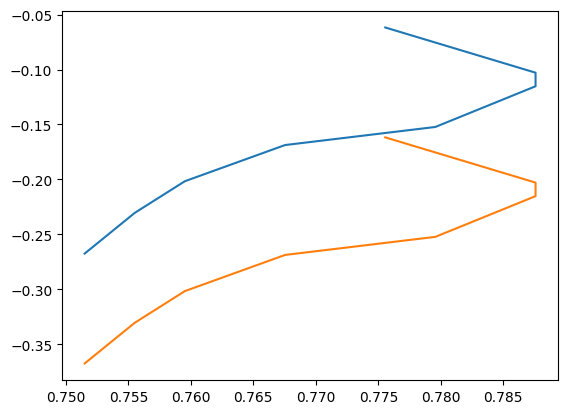

In [32]:
raw_batch = next(dl_iter)
batch = preprocess(raw_batch)[0]

batch_r90 = apply_affine_transform(batch, "shift_down")

plt.plot(batch[:, 0], batch[:, 1])
plt.plot(batch_r90[:, 0], batch_r90[:, 1])
plt.show()

In [48]:
import random

random.random() * 0.15 + 0.05

0.1904809946956682

In [4]:
def _iterate_normalized_actions(
    dataset: LeRobotDataset,
    normalizer: NormalizerProcessorStep,
    n_steps: int | None = None,
):
    if n_steps is None:
        n_steps = len(dataset)

    for i in tqdm(range(n_steps), desc="Iterating dataset for actions"):
        a = dataset[i]["action"].unsqueeze(0)  # shape: (horizon, action_dim)
        a_norm = normalizer._normalize_action(torch.as_tensor(a, dtype=torch.float32), inverse=False)
        yield a_norm
        
actions_iter = _iterate_normalized_actions(dataset, normalizer, n_steps=1000)

In [5]:
def calc_rmse(iterator, coder):
    res = 0
    for act in iterator:
        with torch.no_grad():
            decoded_actions, _, _ = coder(act)
            error: torch.tensor = torch.sqrt((decoded_actions - act)**2)
            res += error.sum(dim=1)
    return res

In [82]:
hyperparameters = {
    "encoded_dim": 2,
    "emdedding_dim": 128,
    "vocab_size": 512,
    "base_features": 24,
    "ratios": [1, 2, 1],
    "num_residual_layers": 6,
    "num_lstm_layers": 4,
}

model = Autoencoder(**hyperparameters)

checkpoint_path = "auto_encoder_8_len_enc_2_transforms.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print(calc_rmse(actions_iter, model))

Iterating dataset for actions: 100%|██████████| 1000/1000 [00:26<00:00, 37.40it/s]

tensor([[38.5952, 36.5379]])


In [10]:
from lerobot.policies.smolandfast.tokenizer_with_diffusion import DiffusionAE

hyperparameters = {
    # encoder
    "base_features": 24,
    "ratios": [1, 2, 1],
    "num_residual_layers": 6,
    "num_lstm_layers": 4,
    "horizon": 8,
    
    # vq
    "encoded_dim": 2,
    "emdedding_dim": 128,
    "vocab_size": 512,
    
    # diffusion
    "n_layer": 12,
    "n_head": 8,
    "n_emb": 768,
    "n_cond_layers": 4,
    
    "num_train_timesteps": 50,
    "prediction_type": 'epsilon',
}
diff_model = DiffusionAE(**hyperparameters)

checkpoint_path = "diffusion_8_high_lr.pth"
checkpoint = torch.load(checkpoint_path)
diff_model.load_state_dict(checkpoint['model_state_dict'])
diff_model.eval()

DiffusionAE(
  (encoder): Encoder(
    (conv_in): Conv1d(2, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv_body): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ELU(alpha=1.0)
          (1): Conv1d(24, 12, kernel_size=(3,), stride=(1,), padding=(1,))
          (2): ELU(alpha=1.0)
          (3): Conv1d(12, 24, kernel_size=(1,), stride=(1,))
        )
        (shortcut): Identity()
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ELU(alpha=1.0)
          (1): Conv1d(24, 12, kernel_size=(3,), stride=(1,), padding=(1,))
          (2): ELU(alpha=1.0)
          (3): Conv1d(12, 24, kernel_size=(1,), stride=(1,))
        )
        (shortcut): Identity()
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ELU(alpha=1.0)
          (1): Conv1d(24, 12, kernel_size=(3,), stride=(1,), padding=(1,))
          (2): ELU(alpha=1.0)
          (3): Conv1d(12, 24, kernel_size=(1,), stride=(1,))
        )
        (shortcu

In [11]:
actions_iter = _iterate_normalized_actions(dataset, normalizer, n_steps=1000)

act = next(actions_iter)

Iterating dataset for actions:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[[ 51,  17],
         [ 81,  75],
         [ 81, 234],
         [ 22, 492]]]) tensor([[[ 51,  17],
         [ 81,  75],
         [ 81, 234],
         [ 22, 492]]])
tensor([[[ 0.8496,  1.0000],
         [ 0.8283,  1.0000],
         [ 0.5662,  1.0000],
         [-0.4645, -0.3109],
         [ 0.8586,  1.0000],
         [-1.0000,  0.9568],
         [ 0.9084,  1.0000],
         [-0.1707,  1.0000]]])


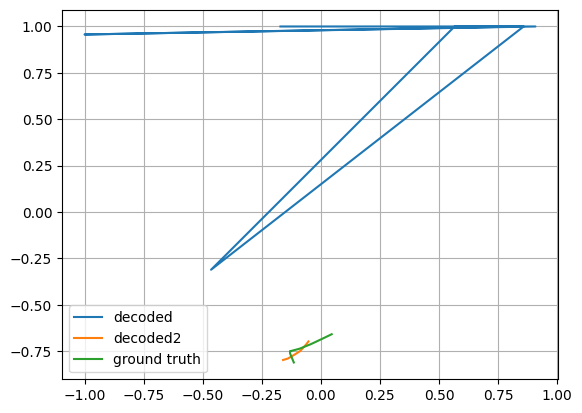

In [15]:

encoded = diff_model.encode(act)
decoded = diff_model.decode(encoded, num_inference_steps=50)

decoded2, encoded2, _ = diff_model(act)
decoded2 = decoded2.cpu().detach().numpy()

print(encoded, encoded2)
print(decoded)

plt.plot(decoded[0, :, 0], decoded[0, :, 1], label="decoded")
plt.plot(decoded2[0, :, 0], decoded2[0, :, 1], label="decoded2")
plt.plot(act[0, :, 0], act[0, :, 1], label="ground truth")

plt.legend()
plt.grid()
plt.show()

In [5]:
def distance(decoded_data, orig_data, n):
    return ((decoded_data[n, 0] - orig_data[n, 0]) ** 2 + (decoded_data[n, 1] - orig_data[n, 1]) ** 2) ** 0.5

In [ ]:
checkpoint_path = "auto_encoder_new.pth"
checkpoint = torch.load(checkpoint_path)
hyperparameters = {
    "encoded_dim": 3,
    "vocab_size": 2048,
    "base_features": 32,
    "ratios": [2, 2, 1],
    "num_residual_layers": 3,
    "num_lstm_layers": 3,
}

model = Autoencoder(
    encoded_dim=hyperparameters["encoded_dim"],
    base_features=hyperparameters["base_features"],
    ratios=hyperparameters["ratios"],
    num_residual_layers=hyperparameters["num_residual_layers"],
    num_lstm_layers=hyperparameters["num_lstm_layers"],
    vocab_size=hyperparameters["vocab_size"],
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

TypeError: Autoencoder.__init__() missing 1 required positional argument: 'vocab_size'

In [7]:
raw_batch = next(dl_iter)
batch = preprocessor(raw_batch)

with torch.no_grad():
    decoded_actions, _ = model(batch["action"])

error:torch.tensor = torch.sqrt((decoded_actions - batch["action"])**2)

print(f"RMSE {(error.mean(dim=1)*100).tolist()}%")

decoded_data = decoded_actions.cpu()[0]
orig_data = batch["action"].cpu()[0]

print("Distance at 5th:", distance(decoded_data, orig_data, 4))
print("Distance at 10th:", distance(decoded_data, orig_data, 9))


# fast_action_tokens = policy.model.fast_tokenizer(batch["action"].detach().cpu())

# decoded_actions_fast = torch.tensor(
#     [
#         policy.model.decode_actions_with_fast(
#             [tok],
#             time_horizon=policy.model.action_horizon,
#             action_dim=policy.model.action_dim,
#             relaxed_decoding=policy.model.config.relaxed_action_decoding,
#         ).squeeze(0)
#         for tok in fast_action_tokens
#     ],
#     dtype=torch.float32,
#     device=device,
# )
# error1:torch.tensor = torch.sqrt((decoded_actions_fast - batch["action"])**2)
# print(f"RMSE fast {(error1.mean(dim=1)*100).tolist()}%")

# decoded_fast_data = decoded_actions_fast.cpu()[0]

plt.plot(decoded_data[:, 0], decoded_data[:, 1], label="decoded")
# plt.plot(decoded_fast_data[:, 0], decoded_fast_data[:, 1], label="decoded fast")
plt.plot(orig_data[:, 0], orig_data[:, 1], label="ground truth")

plt.legend()
plt.grid()
plt.show()

NameError: name 'model' is not defined

In [25]:
def velocity_loss(pred, target):
        """Calculates the MSE of the first-order differences (velocity)."""
        pred_vel = torch.diff(pred, dim=1) # Difference along the sequence axis
        target_vel = torch.diff(target, dim=1)
        return nn.MSELoss()(pred_vel, target_vel)

def criterion(reconstructed, sample_data, l2_loss=[0, 4, 9, 11], l1_coeff=0.5, l2_coeff=1.0, vel_coeff=0.7):
    loss = l1_coeff * nn.L1Loss()(reconstructed, sample_data)
    print("L1:", l1_coeff * nn.L1Loss()(reconstructed, sample_data))
    if l2_loss:
        loss += l2_coeff * torch.sqrt(nn.MSELoss()(reconstructed[:, l2_loss, :], sample_data[:, l2_loss, :]))
        print("L2:", l2_coeff * torch.sqrt(nn.MSELoss()(reconstructed[:, :, :], sample_data[:, :, :])))

    loss += vel_coeff * velocity_loss(reconstructed, sample_data)
    print("Vel:", vel_coeff * velocity_loss(reconstructed, sample_data))
    return loss

print(criterion(decoded_actions[[0]], batch["action"][[0]]))
print(decoded_actions[[0]])
print(batch["action"][[0]])

L1: tensor(0.0007, device='cuda:0')
L2: tensor(0.0017, device='cuda:0')
Vel: tensor(1.3493e-06, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor([[[-0.4444,  0.3166],
         [-0.4441,  0.3168],
         [-0.4452,  0.3168],
         [-0.4437,  0.3174],
         [-0.4432,  0.3179],
         [-0.4430,  0.3186],
         [-0.4424,  0.3189],
         [-0.4420,  0.3193],
         [-0.4421,  0.3199],
         [-0.4395,  0.3196],
         [-0.4401,  0.3180],
         [-0.4420,  0.3150]]], device='cuda:0')
tensor([[[-0.4469,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169],
         [-0.4429,  0.3169]]], device='cuda:0')


In [47]:
decoded_actions, _ = model(batch["action"][[0]])
tokens = torch.round(model.encoder(batch["action"][[0]])).to(torch.int32)
decoded_actions_new = model.decoder(tokens, 12)

In [48]:
print(decoded_actions)
print(decoded_actions_new)

tensor([[[-0.3186, -0.2178],
         [-0.3090, -0.1957],
         [-0.2983, -0.1712],
         [-0.2870, -0.1513],
         [-0.2763, -0.1356],
         [-0.2646, -0.1251],
         [-0.2550, -0.1149],
         [-0.2452, -0.1076],
         [-0.2367, -0.1001],
         [-0.2276, -0.0948],
         [-0.2183, -0.0950],
         [-0.2101, -0.0997]]], device='cuda:0', grad_fn=<PermuteBackward0>)
tensor([[[-0.3186, -0.2178],
         [-0.3090, -0.1957],
         [-0.2983, -0.1712],
         [-0.2870, -0.1513],
         [-0.2763, -0.1356],
         [-0.2646, -0.1251],
         [-0.2550, -0.1149],
         [-0.2452, -0.1076],
         [-0.2367, -0.1001],
         [-0.2276, -0.0948],
         [-0.2183, -0.0950],
         [-0.2101, -0.0997]]], device='cuda:0', grad_fn=<PermuteBackward0>)


In [65]:
(0.9172 - 0.9399) ** 2 + (0.7675 - 0.7490) ** 2

0.0008575399999999958

In [66]:
(0.9172 - 0.9399)

-0.022699999999999942

RMSE [[2.0154263973236084, 0.5436207056045532], [1.1662936210632324, 1.1534708738327026], [1.2673413753509521, 1.3239132165908813], [1.3695049285888672, 1.1790474653244019], [1.386830449104309, 1.0886356830596924], [1.369231939315796, 1.7585426568984985], [1.7057075500488281, 1.0407990217208862], [2.0837080478668213, 1.526963233947754], [2.181645393371582, 1.5450085401535034], [1.9458811283111572, 1.7380008697509766], [2.0513181686401367, 0.6576716899871826], [1.9090757369995117, 1.2803982496261597], [0.6428055763244629, 0.9573056101799011], [1.765175700187683, 2.096774101257324], [1.6420077085494995, 1.7387655973434448], [1.9310766458511353, 2.513127088546753], [1.858385682106018, 1.7181720733642578], [1.1454073190689087, 1.2345671653747559], [2.067185878753662, 1.520005226135254], [1.2107949256896973, 1.0745875835418701], [0.8482798933982849, 1.418042540550232], [0.5837763547897339, 0.8436347246170044], [2.1017227172851562, 2.152831554412842], [1.9460949897766113, 2.1066606044769287]

/tmp/ipykernel_72360/643127299.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  decoded_actions = torch.tensor(


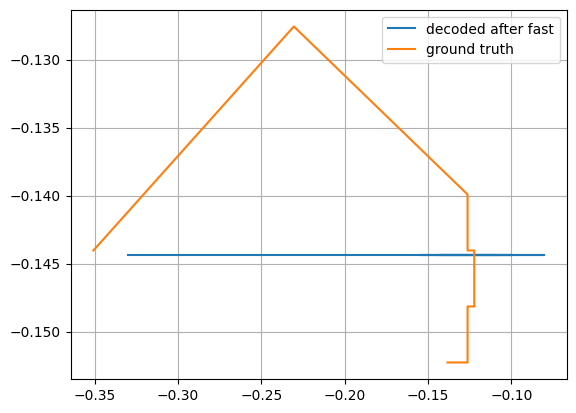

In [44]:

fast_action_tokens = policy.model.fast_tokenizer(batch["action"].detach().cpu())

decoded_actions = torch.tensor(
    [
        policy.model.decode_actions_with_fast(
            [tok],
            time_horizon=policy.model.action_horizon,
            action_dim=policy.model.action_dim,
            relaxed_decoding=policy.model.config.relaxed_action_decoding,
        ).squeeze(0)
        for tok in fast_action_tokens
    ],
    dtype=torch.float32,
    device=device,
)

error:torch.tensor = torch.sqrt((decoded_actions - batch["action"])**2)

print(f"RMSE {(error.mean(dim=1)*100).tolist()}%")

decoded_data = decoded_actions.cpu()[0]
orig_data = batch["action"].cpu()[0]

print("Distance at 5th:", distance(decoded_data, orig_data, 4))
print("Distance at 10th:", distance(decoded_data, orig_data, 9))


plt.plot(decoded_data[:, 0], decoded_data[:, 1], label="decoded after fast")
plt.plot(orig_data[:, 0], orig_data[:, 1], label="ground truth")
plt.legend()
plt.grid()
plt.show()
